In [1]:
# mod
!pip install vietocr==0.3.5 -q

^C


In [3]:
!git clone https://github.com/ducviet00/craft-text-detector.git 
%cd craft-text-detector
!pip install -r requirements.txt
!pip install .

Cloning into 'craft-text-detector'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 202 (delta 24), reused 25 (delta 10), pack-reused 151
Receiving objects: 100% (202/202), 1.51 MiB | 26.74 MiB/s, done.
Resolving deltas: 100% (90/90), done.
/content/craft-text-detector
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
Processing /content/craft-text-detector
  Created wheel for craft-text-detector: filename=craft_text_detector-0.3.3-cp37-none-any.whl size=17970 sha256=302bf3c16caf4643a35971b65e91c3b167d9b93f3e840e726524d8d43d23d6fc
  Stored in directory: /root/.cache/pip/wheels/70/57/ae/6e3018d597488365087c1f19bdcca289893fe55d19f31cd72e
Successfully built craft-text-detector


In [2]:
import matplotlib.pyplot as plt
import glob
import cv2

In [5]:
from PIL import Image, ImageDraw

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

config = Cfg.load_config_from_name('vgg_transformer')
config['weights'] = 'https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA'
config['cnn']['pretrained']=False
config['device'] = 'cpu'
config['predictor']['beamsearch']=False
detector = Predictor(config)

Cached Downloading: /root/.cache/gdown/https-COLON--SLASH--SLASH-drive.google.com-SLASH-uc-QUESTION-id-EQUAL-13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA
Downloading...
From: https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA
To: /root/.cache/gdown/tmprw7_g9fa/dl
152MB [00:01, 130MB/s]


In [6]:
plt.figure(figsize=(20, 12))
plt.imshow(src)

NameError: ignored

<Figure size 1440x864 with 0 Axes>

In [ ]:
image_paths = glob.glob('/content/drive/MyDrive/2020/Myrica/Sample/*.jpg')

In [19]:
import numpy as np
import sys
import cv2 as cv

"""
Modify from : https://docs.opencv.org/4.1.2/dd/dd7/tutorial_morph_lines_detection.html
Add binary result and  
"""



# Load the image
src = cv2.imread("aligned.jpg", cv2.IMREAD_COLOR)
# Check if image is loaded fine
assert src is not None

# Transform source image to gray if it is not already
if len(src.shape) != 2:
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
else:
    gray = src
    

# Apply adaptiveThreshold at the bitwise_not of gray, notice the ~ symbol
gray = cv2.bitwise_not(gray)
bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
                            cv2.THRESH_BINARY, 15, -2)

# Create the images that will use to extract the horizontal and vertical lines
vertical = np.copy(bw)


# Specify size on vertical axis
rows = vertical.shape[0]
verticalsize = rows // 10
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
# Apply morphology operations
vertical = cv2.erode(vertical, verticalStructure)
vertical = cv2.dilate(vertical, verticalStructure)
find_cnt = vertical
# Inverse vertical image
vertical = cv2.bitwise_not(vertical)

# Sometime, the table misses very top or bottom horizontal line. We need to draw it back.
contours, hierarchy = cv.findContours(find_cnt, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
x_max = y_max = -1
x_min = y_min = np.inf
for cnt in contours:
    x_min = min(x_min, cnt.reshape(-1, 2).min(axis=0)[0])
    x_max = max(x_max, cnt.reshape(-1, 2).max(axis=0)[0])
    y_min = min(y_min, cnt.reshape(-1, 2).min(axis=0)[1])
    y_max = max(y_min, cnt.reshape(-1, 2).max(axis=0)[1])

bw = cv2.line(bw, (x_min, y_min), (x_max, y_min), (255, 255, 255), 3)
bw = cv2.line(bw, (x_max, y_max), (x_min, y_max), (255, 255, 255), 3)

horizontal = np.copy(bw)
# Specify size on horizontal axis
cols = horizontal.shape[1]
horizontal_size = cols // 10
# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
# Apply morphology operations
horizontal = cv2.erode(horizontal, horizontalStructure)
horizontal = cv2.dilate(horizontal, horizontalStructure)
horizontal = cv2.bitwise_not(horizontal)


'''
Extract edges and smooth image according to the logic
1. extract edges
2. dilate(edges)
3. src.copyTo(smooth)
4. blur smooth img
5. smooth.copyTo(src, edges)
'''
# Step 1
edges = cv2.adaptiveThreshold(vertical, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
                            cv2.THRESH_BINARY, 3, -2)

# Step 2
kernel = np.ones((3, 4), np.uint8)
# edges = cv2.dilate(edges, kernel)

# Step 3
smooth = np.copy(vertical)
# Step 4
smooth = cv2.blur(smooth, (2, 2))
# Step 5
(rows, cols) = np.where(edges != 0)
vertical[rows, cols] = smooth[rows, cols]
# Show final result

# horizontal
edges1 = cv2.adaptiveThreshold(horizontal,255,cv2.ADAPTIVE_THRESH_MEAN_C, \
                                cv2.THRESH_BINARY,3, -2)

kernel = np.ones((3, 3), np.uint8)
edges1 = cv2.dilate(edges1, kernel)
# Step 3
smooth1 = np.copy(horizontal)
# Step 4
smooth1 = cv2.blur(smooth1, (2, 2))
# Step 5
(rows, cols) = np.where(edges1 != 0)
horizontal[rows, cols] = smooth1[rows, cols]

result = cv2.bitwise_and(horizontal, vertical)

#Finally, apply binary threshold to result
result = cv2.threshold(result, 225, 255, cv2.THRESH_BINARY)[1]

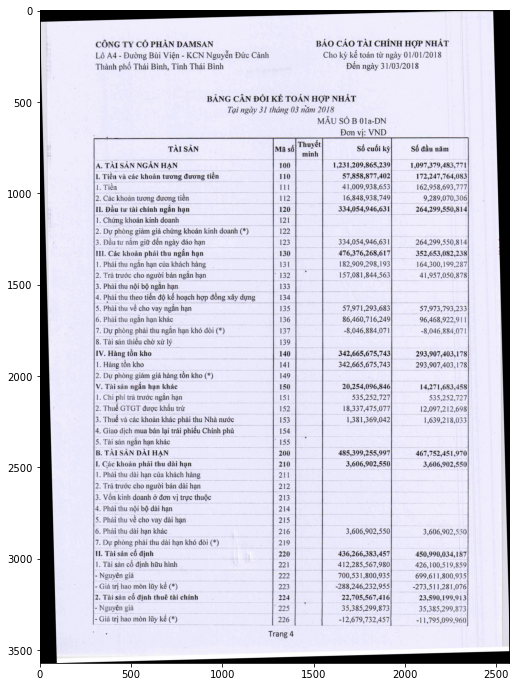

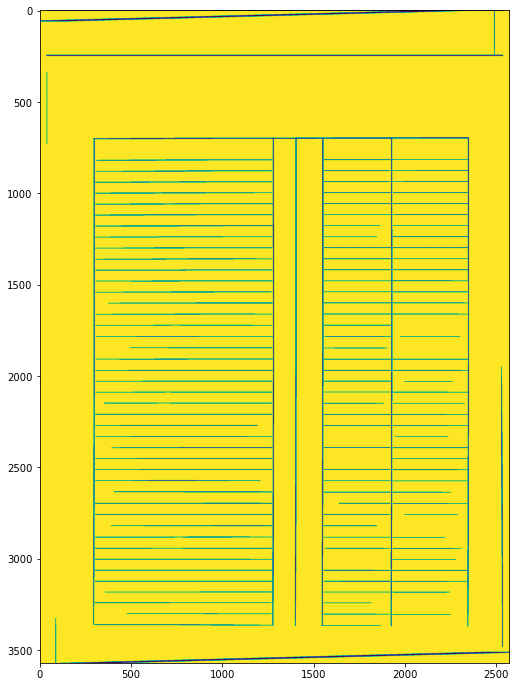

In [20]:
plt.figure(figsize=(20, 12))
plt.imshow(src)
plt.show()

plt.figure(figsize=(20, 12))
plt.imshow(result)

In [ ]:
_, labels, stats,_ = cv2.connectedComponentsWithStats(result, connectivity=4, ltype=cv2.CV_32S)

In [ ]:
from craft_text_detector import Craft

In [ ]:
x, y, w, h

(1358, 2037, 183, 38)

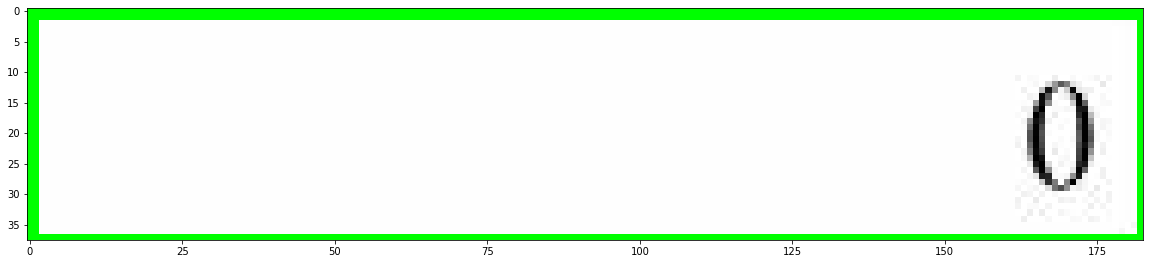

In [ ]:
plt.figure(figsize=(20, 12))

plt.imshow(src[y:y+h, x:x+w])

In [ ]:
import craft_text_detector.predict as predict

get_prediction = predict.get_prediction
prediction_result = get_prediction(
            image=image,
            craft_net=load_craftnet_model(self.cuda),
            refine_net=load_refinenet_model(self.cuda),
            text_threshold=self.text_threshold,
            link_threshold=self.link_threshold,
            low_text=self.low_text,
            cuda=self.cuda,
            long_size=self.long_size,
        )
# create a craft instance
craft = Craft(crop_type="box", cuda=False)

# apply craft text detection and export detected regions to output directory
prediction_result = craft.detect_text(image_path)

# unload models from ram/gpu
craft.unload_craftnet_model()
craft.unload_refinenet_model()

In [ ]:
img = Image.fromarray(src[y:y+h, x:x+w])
detector.predict(img)

'0390000000'

162
Eli
THỊ TÀI SẢN
Mã số
Thuyết minh
Số cuối năm
Số đầu năm
039100100199
2
3
4
5
A - TÀI SẢN NGẮN HẠN (100 ? 110% 120 + 130 % 140 ? 150)
100
Consection
5.922.829.001
5.019.094.669
I. Tiền và các khoản tương đương tiền (110 ? 111 ? 112)
110
STATES
3.011.488.616
1.893.654.815
1.Tiền
111
States
3.011.488.616
1.893.654.815
2. Các khoản tương đương tiền
112
Consection
038000000
038000000
II. Đầu tư tài chính ngắn hạn (120 ? 121?122 + 123)
120
Consection
038000000
038000000
1. Chứng khoán kinh doanh
121
Consection
038000000
038000000
2. Dự phòng giảm giá chứng khoán kinh doanh (?) (2)
122
Contraction
039000000
039000000
3. Đầu tư năm giữ đến ngày đáo hạn
123
Consection
039000000
039000000
III. Các khoản phải thu ngắn hạn (130 ? 131 ? 132 %...+ 137 % 139)
130
Consection
117.470.012
129.251.870
117.470.012
1. Phải thu ngắn hạn của khách hàng
131
STATES
129.251.870
2. Trả trước cho người bán ngăn hạn
132
Consection
038000000
038000000
3. Phải thu nội bộ ngắn hạn
133
Consection
038000000
038000

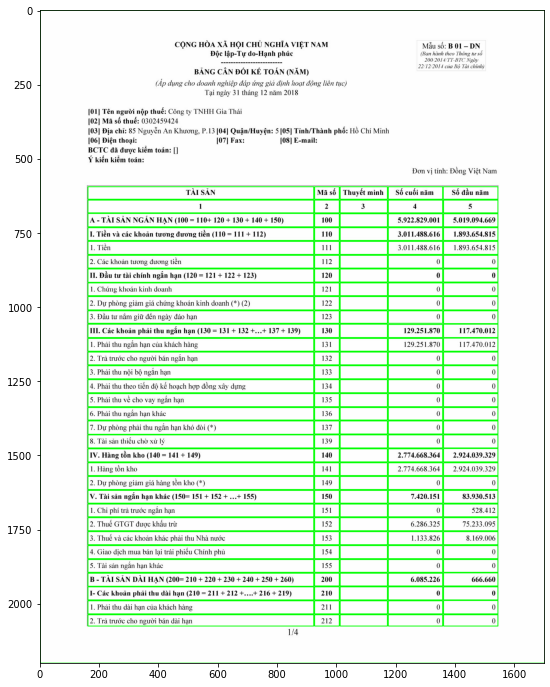

In [ ]:
print(len(stats))
for x, y, w, h, area in stats[1:]: 
    cv2.rectangle(src, (x,y), (x+w,y+h), (0,255,0), 2)
    img = Image.fromarray(src[y:y+h, x:x+w])
    s = detector.predict(img)
    print(s)
plt.figure(figsize=(20, 12))
plt.imshow(src)    

In [ ]:
pip install easyocr

In [ ]:
import easyocr
reader = easyocr.Reader(['vi','vi'])

In [ ]:
reader.readtext(src[y:y+h, x:x+w])

[]

In [ ]:
!git clone https://github.com/ducviet00/craft-text-detector.git

fatal: destination path 'craft-text-detector' already exists and is not an empty directory.
